In [0]:
# Check the model is running on GPU
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [0]:
# Importing the libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from keras.models import load_model
import pickle
from pickle import dump
from numpy import array
import re
from os import listdir
from pickle import dump
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.inception_v3 import preprocess_input
from keras.models import Model
from keras.utils import to_categorical
from keras.models import model_from_json
from keras.models import load_model

Using TensorFlow backend.


In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
root_path = 'gdrive/My Drive/Colab Notebooks/Projects/Image_Captioning/'  #change dir to your project folder

In [0]:
dataset = pd.read_csv(root_path + 'results.csv', sep = '|')
dataset.isnull().sum()
dataset = dataset.fillna(method = 'ffill')

In [0]:
dataset.shape

(158915, 3)

In [0]:
dataset = dataset.iloc[:25000,:]

In [0]:
dataset.tail()

,image_name,comment_number,comment
24995,2330062180.jpg,0,A golden dog bounds across the snow-covered h...
24996,2330062180.jpg,1,a white dog is running through the snow .
24997,2330062180.jpg,2,A dog running down a snow covered hill
24998,2330062180.jpg,3,A white dog running through the snow
24999,2330062180.jpg,4,A dog running through snow .


In [0]:
def photo_description(dataset):   
    description = {}
    comments_len = []
    for i in range(0, dataset.shape[0] - 5, 5):
        image_name = dataset['image_name'][i]
        image_name = image_name.split('.')[0]
        comments = list(dataset[' comment'][i:i+5].values)

        for j in range(0, 5):
            comment = re.sub('[^a-zA-Z]', ' ', comments[j])
            comment = comment.lower()
            comments[j] = 'startseq ' + comment + ' endseq'
            words = comments[j].split()
            comments_len.append(len(words))

        description[image_name] = comments
    
    return description

In [0]:
def maximum_length(dataset):   
    comments_len = []
    for i in range(0, dataset.shape[0] - 5, 5):
        image_name = dataset['image_name'][i]
        image_name = image_name.split('.')[0]
        comments = list(dataset[' comment'][i:i+5].values)

        for j in range(0, 5):
            comment = re.sub('[^a-zA-Z]', ' ', comments[j])
            comment = comment.lower()
            comments[j] = 'startseq ' + comment + ' endseq'
            words = comments[j].split()
            comments_len.append(len(words))

    
    return max(comments_len)

In [0]:
max_length = maximum_length(dataset)
description = photo_description(dataset)

In [0]:
max_length

80

In [0]:
from os import listdir
from pickle import dump
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.inception_v3 import preprocess_input
from keras.models import Model

# extract features from each photo in the directory
def extract_features(directory):
    # load the model
    model = InceptionV3()
    # re-structure the model
    model.layers.pop()
    model = Model(inputs=model.inputs, outputs=model.layers[-1].output)
    # summarize
    print(model.summary())
    # extract features from each photo
    features = dict()
    for name in listdir(directory):
        # load an image from file
        filename = directory + '/' + name
        image = load_img(filename, target_size=(299, 299))
        # convert the image pixels to a numpy array
        image = img_to_array(image)
        # reshape data for the model
        image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
        # prepare the image for the VGG model
        image = preprocess_input(image)
        # get features
        feature = model.predict(image, verbose=0)
        # get image id
        image_id = name.split('.')[0]
        # store feature
        features[image_id] = feature
        print('>%s' % name)
    return features



In [0]:
# extract features from all images
directory = root_path
features = extract_features(directory)
print('Extracted Features: %d' % len(features))
# save to file
dump(features, open(root_path + 'features.pkl', 'wb'))

In [0]:
open_file = open(root_path + 'features.pkl', "rb")
photos = pickle.load(open_file)
open_file.close()

In [0]:
word_to_vec_map = {}
word_to_index = {}
index_to_word = {}
with open(root_path + 'glove.6B.200d.txt', encoding = 'utf8' ) as f:
    for i, line in enumerate(f):
        element=line.split()
        word = element[0]
        vector_values = np.array(element[1:], dtype=float)
        word_to_index [word] = (i+1)
        index_to_word [i+1] = word
        word_to_vec_map [word] = vector_values

In [0]:
all_embs = np.stack(word_to_vec_map.values())
emb_mean,emb_std = all_embs.mean(), all_embs.std()
emb_mean,emb_std

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  """Entry point for launching an IPython kernel.


(-0.008671859820026773, 0.3818620572721229)

In [0]:
vocab_size = len(word_to_index) + 1
embedding_dim = 200
# Get 200-dim dense vector for each of the 10000 words in out vocabulary
embedding_matrix = np.random.normal(emb_mean, emb_std, (vocab_size, embedding_dim))
for word, i in word_to_index.items():
    #if i < max_words:
    embedding_vector = word_to_vec_map.get(word)
    if embedding_vector is not None:
        # Words not found in the embedding index will be all zeros
        embedding_matrix[i] = embedding_vector

In [0]:
# fit a tokenizer given caption descriptions
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
def to_lines(description):
    all_desc = list()
    for key in description.keys():
        [all_desc.append(d) for d in description[key]]
    return all_desc


def create_tokenizer(description):
    lines = to_lines(description)
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer
tokenizer = create_tokenizer(description)

In [0]:
# create sequences of images, input sequences and output words for an image
def data_generator(tokenizer, description, photos, vocab_size, max_length, num_photos_per_batch):
    X1, X2, y = list(), list(), list()
    n=0
    # walk through each image identifier
    while True:
        for key, desc_list in description.items():
            n+=1
            # walk through each description for the image
            for desc in desc_list:
                # encode the sequence
                seq = tokenizer.texts_to_sequences([desc])[0]
                # split one sequence into multiple X,y pairs
                for i in range(1, len(seq)):
                    # split into input and output pair
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    # store
                    X1.append(photos[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == n==num_photos_per_batch:
                yield [[array(X1), array(X2)], array(y)]
                X1, X2, y = list(), list(), list()
                n=0

    

In [0]:
import keras
from keras.models import Model, Sequential
from keras.layers import Dense, Dropout, Embedding, LSTM, Add, Input

# image feature extractor model
inputs1 = Input(shape=(2048,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)

# partial caption sequence model
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, embedding_dim, trainable=True, weights=[embedding_matrix])(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256)(se2)

# decoder (feed forward) model
decoder1 = Add()([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

# merge the two input models
model = Model(inputs=[inputs1, inputs2], outputs=outputs)


In [0]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 80)           0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 2048)         0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 80, 200)      80000200    input_4[0][0]                    
__________________________________________________________________________________________________
dropout_3 (Dropout)             (None, 2048)         0           input_3[0][0]                    
__________________________________________________________________________________________________
dropout_4 

In [0]:
model.compile(loss='categorical_crossentropy', optimizer='adam')

In [0]:
epochs = 20
num_photos_per_batch = 3
steps = len(description)//num_photos_per_batch


In [0]:
for i in range(epochs):
    generator = data_generator(tokenizer, description, photos, vocab_size, max_length, num_photos_per_batch)
    model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)
    if (i+1)%5 == 0:
      model.save(root_path + 'model_' + str(i) + '.h5')
   

W0813 16:33:08.796932 139921983141760 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/1
1666/1666 [==============================] - 1199s 720ms/step - loss: 4.9265
Epoch 1/1
1666/1666 [==============================] - 1195s 718ms/step - loss: 4.0176
Epoch 1/1
1666/1666 [==============================] - 1198s 719ms/step - loss: 3.7298
Epoch 1/1
1666/1666 [==============================] - 1193s 716ms/step - loss: 3.5430
Epoch 1/1
1666/1666 [==============================] - 1199s 720ms/step - loss: 3.4056
Epoch 1/1
1666/1666 [==============================] - 1196s 718ms/step - loss: 3.2915
Epoch 1/1
1666/1666 [==============================] - 1196s 718ms/step - loss: 3.1998
Epoch 1/1
1666/1666 [==============================] - 1199s 720ms/step - loss: 3.1259
Epoch 1/1
1666/1666 [==============================] - 1206s 724ms/step - loss: 3.0645
Epoch 1/1
1666/1666 [==============================] - 1221s 733ms/step - loss: 3.0104
Epoch 1/1
1666/1666 [==============================] - 1221s 733ms/step - loss: 2.9641
Epoch 1/1
1666/1666 [======================

In [0]:
model.load_weights(root_path + 'model_19.h5')



In [0]:
# extract features for test image
root_path = 'gdrive/My Drive/Colab Notebooks/Projects/Image_Captioning/'
directory = root_path + 'test/'
features = extract_features(directory)
print('Extracted Features: %d' % len(features))
# save to file
dump(features, open(root_path + 'features_test.pkl', 'wb'))

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
conv2d_95 (Conv2D)              (None, 149, 149, 32) 864         input_6[0][0]                    
__________________________________________________________________________________________________
batch_normalization_95 (BatchNo (None, 149, 149, 32) 96          conv2d_95[0][0]                  
__________________________________________________________________________________________________
activation_95 (Activation)      (None, 149, 149, 32) 0           batch_normalization_95[0][0]     
__________________________________________________________________________________________________
conv2d_96 

In [0]:
list(features.values())[0]

array([[0.0376907 , 0.05041323, 0.4920252 , ..., 0.10093078, 0.743736  ,
        0.21055347]], dtype=float32)

In [0]:
# map an integer to a word
def word_for_id(integer, tokenizer):
	for word, index in tokenizer.word_index.items():
		if index == integer:
			return word
	return None


In [0]:

# generate a description for an image
def generate_desc(model, tokenizer, photo, max_length):
	# seed the generation process
	in_text = 'startseq'
	# iterate over the whole length of the sequence
	for i in range(max_length):
		# integer encode input sequence
		sequence = tokenizer.texts_to_sequences([in_text])[0]
		# pad input
		sequence = pad_sequences([sequence], maxlen=max_length)
		# predict next word
		yhat = model.predict([photo,sequence], verbose=0)
		# convert probability to integer
		yhat = np.argmax(yhat)
		# map integer to word
		word = word_for_id(yhat, tokenizer)
		# stop if we cannot map the word
		if word is None:
			break
		# append as input for generating the next word
		in_text += ' ' + word
		# stop if we predict the end of the sequence
		if word == 'endseq':
			break
	return in_text

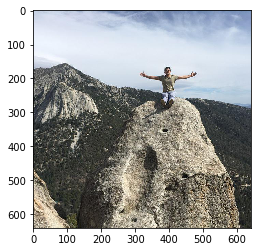

startseq a man is climbing up a cliff over a large rock endseq


In [0]:
x=plt.imread(root_path + 'test/'  + '1.jpg' )
plt.imshow(x)
plt.show()
for i in range (len(features)):
  photo = list(features.values())[i]
  photo = photo.reshape((1,2048))
  print(generate_desc(model, tokenizer, list(features.values())[i], max_length))